In [1]:
# import sys,os
# #### Change "0" to GPU device number you want to use if you have multiple GPU devices
# os.environ['CUDA_VISIBLE_DEVICES'] ="0" 

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [3]:
import tensorflow as tf
import numpy as np
import aux_functions as af
import models as Mo
from attack import Attack
import sys
import time

In [4]:
x_train,y_train,x_test,y_test = af.load_mnist_dataset()

Sample Images ...


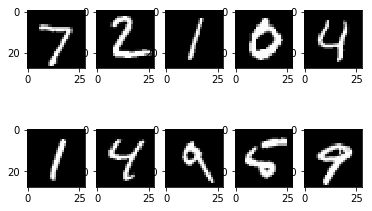

In [5]:
print 'Sample Images ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i,:,:,0])

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))
x = tf.placeholder(tf.float32,[None,28,28,1])
y = tf.placeholder(tf.float32,[None,10])
# target_model = Mo.SimpleCNN2(x,y,sess,var_scope='simpleCNN2',path = './target_model_cnn2')
# target_model.test_model(x_test,y_test)
# sub_model = Mo.SimpleCNN3(x,y,sess,var_scope='simpleCNN3_1')
# sub_model2 = Mo.SimpleCNN3(x,y,sess,var_scope='SimpleCNN3_2')

In [7]:
target_model = Mo.RFNModel(x,y,sess,var_scope='RFNModel',path='./trained_models/RFN_target_model')


INFO:tensorflow:Restoring parameters from ./RFN_target_model


In [8]:
###### Training RFN Model from scratch
# target_model = Mo.RFNModel(x,y,sess,var_scope='RFNModel')
# other_params = {
#     'batch_size':100,
#     'optimizer_name':'SGD'
# }
# target_model.train_model(x_train,y_train,lr=0.1,nb_epochs=25,other_params = other_params)

In [9]:
target_model.training = False
target_model.reuse_graph(x,self_update=True)
target_model.test_model(x_test,y_test,batch_size=100)

model accuracy is: 0.9706


In [10]:
sub_model = Mo.SimpleCNN3(x,y,sess,var_scope='simpleCNN3')


In [11]:
sub_model.SST(x_test,target_model,lr=0.001,nb_epochs=10*7,start_range=0,end_range=100,step=5,batch_size=100)
sub_model.SST(x_test,target_model,lr=0.0001,nb_epochs=5*7,start_range=0,end_range=100,step=5,batch_size=100)


epoch: 70/70 iter: 50/100 loss: 1.0358 
epoch: 35/35 iter: 50/100 loss: 0.8987 


In [12]:
print 'Accuracy of substitute model with SST:'
sub_model.test_model(x_test,y_test)

Accuracy of substitute model with SST:
model accuracy is: 0.9828


# Unbounded Attack 

In [13]:
atk1 = Attack(x,y,[sub_model],target_model,sess,100,lr=0.05)
index = 0
legit_img = x_test[index:index+100]
legit_y = y_test[index:index+100]


Crafting adversarial examples against RFN 50 ...
run: 3/3 iter: 300/300 success rate: 1.0000 
Total attack time: 143.48783493
Success Rate:  1.0
AVG L2 norm of crafted Adv. Examples: 1.596200597652489
Sample Adv. Examples ...


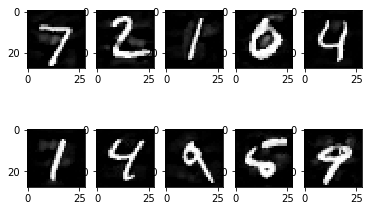

In [14]:
st = time.time()
print 'Crafting adversarial examples against RFN 50 ...'
def adv_cond_50(adv_img_np,true_label):
    result = np.zeros((len(adv_img_np)))
    for i in range(len(adv_img_np)):
        target_model_out_np = sess.run(target_model.labels,{target_model.x:adv_img_np[i:i+1]})
        result[i] = np.max((1-true_label[i])*np.bincount(target_model_out_np,minlength=10)) > 50
    return result
other_params = {
    'total_run':3,
    'total_iters':300,
    'adv_condition':adv_cond_50
}
adv_img1 = atk1.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_l2=0
not_found=0
not_found_indices = []
dset = adv_img1
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_l2+= np.linalg.norm(x_test[i] - dset[i])
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'AVG L2 norm of crafted Adv. Examples:',total_l2/(100.-not_found)
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))

Crafting adversarial examples against RFN 70 ...
run: 3/3 iter: 300/300 success rate: 1.0000 
Total attack time: 140.35106802
Success Rate:  1.0
AVG L2 norm of crafted Adv. Examples: 1.8211132177758091
Sample Adv. Examples ...


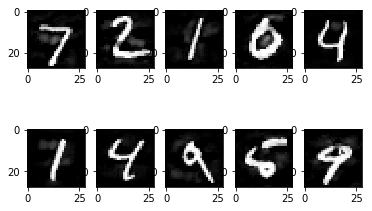

In [15]:
print 'Crafting adversarial examples against RFN 70 ...'
st = time.time()
def adv_cond_70(adv_img_np,true_label):
    result = np.zeros((len(adv_img_np)))
    for i in range(len(adv_img_np)):
        target_model_out_np = sess.run(target_model.labels,{target_model.x:adv_img_np[i:i+1]})
        result[i] = np.max((1-true_label[i])*np.bincount(target_model_out_np,minlength=10)) > 70
    return result
other_params = {
    'total_run':3,
    'total_iters':300,
    'adv_condition':adv_cond_70
}
adv_img2 = atk1.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_l2=0
not_found=0
not_found_indices = []
dset = adv_img2
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_l2+= np.linalg.norm(x_test[i] - dset[i])
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'AVG L2 norm of crafted Adv. Examples:',total_l2/(100.-not_found)
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))

Crafting adversarial examples against RFN 90 ...
run: 3/3 iter: 300/300 success rate: 1.0000 
Total attack time: 144.936637163
Success Rate:  1.0
AVG L2 norm of crafted Adv. Examples: 2.149948961636535
Sample Adv. Examples ...


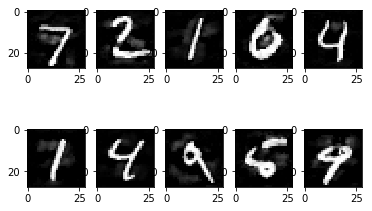

In [16]:
print 'Crafting adversarial examples against RFN 90 ...'
st = time.time()
def adv_cond_90(adv_img_np,true_label):
    result = np.zeros((len(adv_img_np)))
    for i in range(len(adv_img_np)):
        target_model_out_np = sess.run(target_model.labels,{target_model.x:adv_img_np[i:i+1]})
        result[i] = np.max((1-true_label[i])*np.bincount(target_model_out_np,minlength=10)) > 90
    return result
other_params = {
    'total_run':3,
    'total_iters':300,
    'adv_condition':adv_cond_90
}
adv_img3 = atk1.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_l2=0
not_found=0
not_found_indices = []
dset = adv_img3
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_l2+= np.linalg.norm(x_test[i] - dset[i])
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'AVG L2 norm of crafted Adv. Examples:',total_l2/(100.-not_found)
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))

#  Bounded Attack

In [17]:
atk2 = Attack(x,y,[sub_model],target_model,sess,100,lr=0.05,eps=0.25)
index = 0
legit_img = x_test[index:index+100]
legit_y = y_test[index:index+100]


Crafting adversarial examples against RFN-50 ...
run: 3/3 iter: 300/300 success rate: 0.9700 
Total attack time: 144.896859884
Success Rate:  0.97
L-Inf norm of crafted Adv. Examples: 0.2500000406714047
Sample Adv. Examples ...


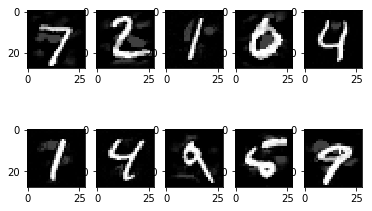

In [18]:
st = time.time()
print 'Crafting adversarial examples against RFN-50 ...'
def adv_cond_50(adv_img_np,true_label):
    result = np.zeros((len(adv_img_np)))
    for i in range(len(adv_img_np)):
        target_model_out_np = sess.run(target_model.labels,{target_model.x:adv_img_np[i:i+1]})
        result[i] = np.max((1-true_label[i])*np.bincount(target_model_out_np,minlength=10)) > 50
    return result
other_params = {
    'total_run':3,
    'total_iters':300,
    'adv_condition':adv_cond_50
}
adv_img4 = atk2.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_linf=0
not_found=0
not_found_indices = []
dset = adv_img4
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_linf=np.maximum(total_linf, np.max(np.abs((x_test[i] - dset[i]))))
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'L-Inf norm of crafted Adv. Examples:',total_linf
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))

Crafting adversarial examples against RFN-70 ...
run: 3/3 iter: 300/300 success rate: 0.9700 
Total attack time: 147.390887022
Success Rate:  0.97
L-Inf norm of crafted Adv. Examples: 0.25000004394381653
Sample Adv. Examples ...


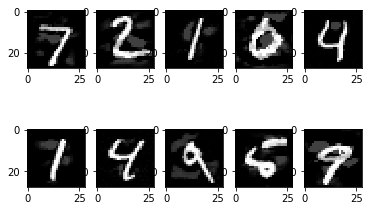

In [19]:
st = time.time()
print 'Crafting adversarial examples against RFN-70 ...'
def adv_cond_70(adv_img_np,true_label):
    result = np.zeros((len(adv_img_np)))
    for i in range(len(adv_img_np)):
        target_model_out_np = sess.run(target_model.labels,{target_model.x:adv_img_np[i:i+1]})
        result[i] = np.max((1-true_label[i])*np.bincount(target_model_out_np,minlength=10)) > 70
    return result
other_params = {
    'total_run':3,
    'total_iters':300,
    'adv_condition':adv_cond_70
}
adv_img5 = atk2.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_linf=0
not_found=0
not_found_indices = []
dset = adv_img5
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_linf=np.maximum(total_linf, np.max(np.abs((x_test[i] - dset[i]))))
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'L-Inf norm of crafted Adv. Examples:',total_linf
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))

Crafting adversarial examples against RFN-90 ...
run: 3/3 iter: 300/300 success rate: 0.8900 
Total attack time: 142.519497156
Success Rate:  0.89
L-Inf norm of crafted Adv. Examples: 0.25000004394381653
Sample Adv. Examples ...


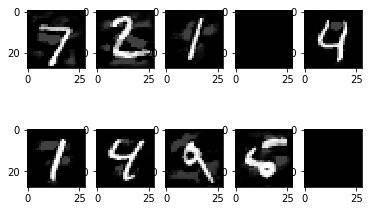

In [20]:
st = time.time()
print 'Crafting adversarial examples against RFN-90 ...'
def adv_cond_90(adv_img_np,true_label):
    result = np.zeros((len(adv_img_np)))
    for i in range(len(adv_img_np)):
        target_model_out_np = sess.run(target_model.labels,{target_model.x:adv_img_np[i:i+1]})
        result[i] = np.max((1-true_label[i])*np.bincount(target_model_out_np,minlength=10)) > 90
    return result
other_params = {
    'total_run':3,
    'total_iters':300,
    'adv_condition':adv_cond_90
}
adv_img6 = atk2.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_linf=0
not_found=0
not_found_indices = []
dset = adv_img6
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_linf=np.maximum(total_linf, np.max(np.abs((x_test[i] - dset[i]))))
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'L-Inf norm of crafted Adv. Examples:',total_linf
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))